In [1]:
%pylab inline
from sklearn.datasets import fetch_openml

Populating the interactive namespace from numpy and matplotlib


## Classification of the MNIST dataset

Chapter 3 classifies images of numbers obtained from the MNIST dataset. 

See that the book has a deprecated function. Use now `fetch_openml`

In [2]:
mnist = fetch_openml('mnist_784',version=1, return_X_y=True)

In [3]:
X,y=mnist[0],mnist[1]

In [4]:
some_digit=X[60000]
some_digit_image=some_digit.reshape(28,28)

(-0.5, 27.5, 27.5, -0.5)

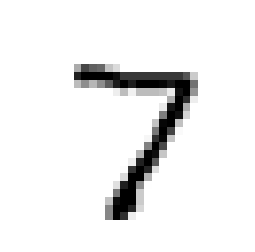

In [5]:
imshow(some_digit_image,cmap='binary',interpolation='nearest')
plt.axis('off')

In [6]:
y[60000]

'7'

The image and the target correspond to each other.

Let's obtain the training and test set. We will do it manually this time instead of using `train_test_split`

In [7]:
X_train, X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

#shuffle the training set
shuffle_index = np.random.permutation(60000)
X_train,y_train = X_train[shuffle_index],y_train[shuffle_index]


## Binary classification

We will start with classifying one number versus the others. Let's do 7

In [8]:
y_train_7 = (y_train=='7')
y_test_7 = (y_test=='7')

We will use the Stochastic Gradient Descent (SDG) which is good for large datsets. This is also useful for online learning. 

In [9]:
from sklearn.linear_model import SGDClassifier

In [10]:
sgd_clf = SGDClassifier(random_state=42,max_iter=1000,tol=1e-3)
sgd_clf.fit(X_train,y_train_7)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([X[60000]])

array([ True])

This data set has the target values as strings. It seems to work though.

## Performance

We will cross-validate the training now. There are two ways to do this. One gives you more control that what we did in chapter 2. We will try both.

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [13]:
skfolds = StratifiedKFold(n_splits=3,random_state=42)

for train_index,test_index in skfolds.split(X_train,y_train_7):
    
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_7[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_7[test_index]
    
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = np.sum(y_pred==y_test_fold)
    print(n_correct/float(len(y_pred)))

0.9772511374431279
0.97825
0.9754487724386219


In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_7,cv=3,scoring='accuracy')

array([0.97725114, 0.97825   , 0.97544877])

This looks good since it seems we classify correctly most of the 7's versus non-7's. Let's see if this is true

In [15]:
from sklearn.base import BaseEstimator

In [16]:
class Never7Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)
    
never_7_clf = Never7Classifier()
cross_val_score(never_7_clf,X_train,y_train_7,cv=3,scoring='accuracy')

array([0.89555, 0.8966 , 0.8946 ])

Close to 90\%. Only about 10\% of the data are 7s, so just guessing that an image is not 7, will give you close to 90%. THe dumb class we made, returns a prediction that there are no sevens, which is why it returns that 90% of the data does a good prediction.
The `accuracy` scoring is not a good  performance measurement when the datasets are skewed.

## Confusion Matrix

A better way to evaluate performan of a classifier is to look at the _confusion matrix_. 

General idea: **Count how many times class A is classified as class B**.

In [17]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_7,cv=3)

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_7,y_train_pred)

array([[53012,   723],
       [  658,  5607]])

Row 1 Column 1: True negatives (Non-7s)

Row 1 Column 2: False positives (wrongly classified as 7s)

Row 2 Column 1: false negatives (wrongly  classified as non-7s)

Row 2 Column 2: True positives

Metrics to look at:

1. Precision

$$ precision = \frac{True Positives}{True Positives + False Positives} $$

2. Recall/Sensitivity/True positive rate

$$ recall = \frac{True Positives}{True Positives + False Negatives} $$

In [19]:
from sklearn.metrics import precision_score, recall_score

In [20]:
precision_score(y_train_7,y_train_pred)

0.885781990521327

In [21]:
recall_score(y_train_7,y_train_pred)

0.8949720670391061

Another metric is the $F_1$-Score and it is the harmonic mean of the precision and recall. Harmonic mean gives much weight to low values, as a result $F_1$ will be high if both precision and recall are high.

$$ F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2\frac{precision\times recall}{precision+recall} $$

$$ F_1 = \frac{TP}{TP+\frac{FN+FP}{2}} $$

In [22]:
from sklearn.metrics import f1_score

In [23]:
f1_score(y_train_7,y_train_pred)

0.8903533148074632

Precision: how well the classifier does

Recall: how many times will the classifier get the right answer. 

Example: precision of 0.3 will have lots of false alerts, but with a recall of 0.9, we know the classifier will classify correctly the class that we are interested. 

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([4243.21037537])

In [25]:
threshold = 0
y_some_digit_pred=(y_scores > threshold)
y_some_digit_pred

array([ True])

In [26]:
threshold = 20000000  #increasing threshold reduces recall
y_some_digit_pred=(y_scores > threshold)
y_some_digit_pred

array([False])

In [27]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_7,cv=3,method='decision_function')

In [28]:
from sklearn.metrics import precision_recall_curve

In [29]:
precisions,recalls,thresholds = precision_recall_curve(y_train_7,y_scores)

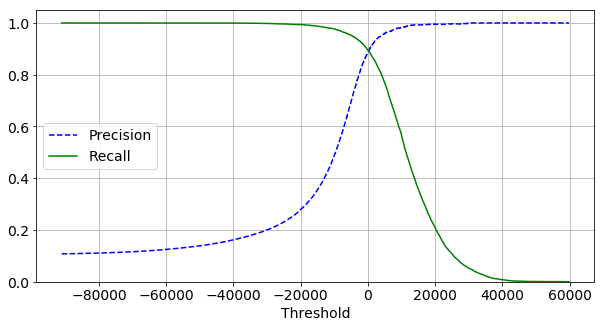

In [30]:
rcParams['figure.figsize']=10,5
rcParams['font.size']=14
plt.plot(thresholds,precisions[:-1],'b--',label='Precision')
plt.plot(thresholds,recalls[:-1],'g-',label="Recall")
plt.xlabel('Threshold')
plt.legend(loc='center left')
plt.ylim(0,1.05)
plt.grid()

(0, 1)

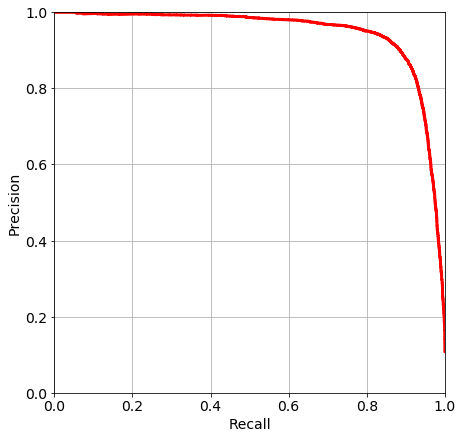

In [31]:
rcParams['figure.figsize']=7,7
plt.plot(recalls[:-1],precisions[:-1],lw=3,color='red')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.xlim(0,1)
plt.ylim(0,1)

## The ROC Curve

The _reciever operation characteristic_ (ROC) curve is the plot of **Recall** against **False Postive Rate**. 

False positive rate is the rate of times some negative instances are classified incorrectly as positive. It is one minues the True Negative rate (TNR), also called __specificity__.

ROC plots sensitivity(recall) versus 1-specificity

In [32]:
from sklearn.metrics import roc_curve

In [33]:
fpr, tpr, thresholds = roc_curve(y_train_7, y_scores)

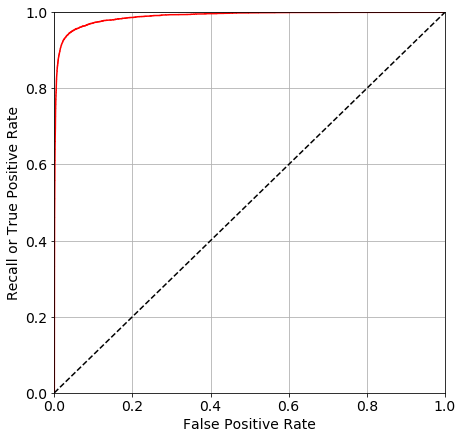

In [34]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,color='red',label=label)
    plt.axis([0,1,0,1])
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("Recall or True Positive Rate")
    plt.grid()
plot_roc_curve(fpr,tpr)

You are in page 94

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_7,y_scores)

0.9890017006546343

Try now with a Random Forest Classifier and compare it to the SGD Classifiers

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_7, cv = 3,
                                    method="predict_proba")

/Users/hugo/Software/miniconda2/envs/st_test/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [38]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_7,y_scores_forest)

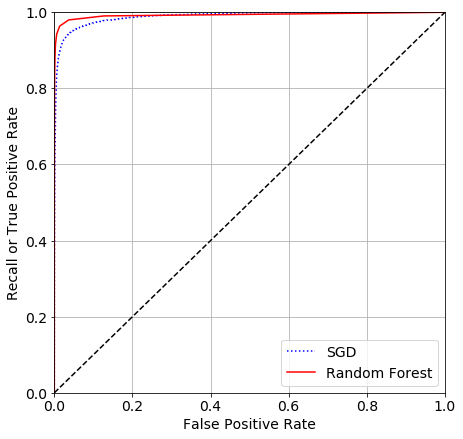

In [39]:
plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
legend(loc="lower right")

In [40]:
roc_auc_score(y_train_7,y_scores_forest)

0.9927409872767625

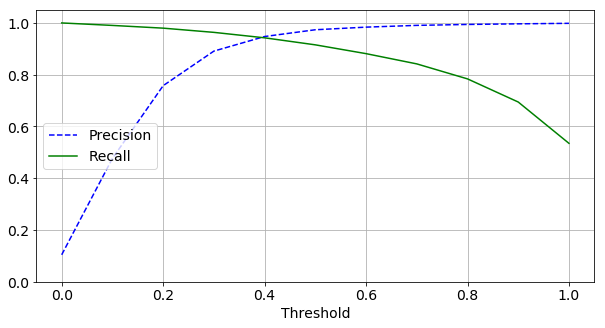

In [41]:
precisions,recalls,thresholds = precision_recall_curve(y_train_7,y_scores_forest)

rcParams['figure.figsize']=10,5
rcParams['font.size']=14
plt.plot(thresholds,precisions[:-1],'b--',label='Precision')
plt.plot(thresholds,recalls[:-1],'g-',label="Recall")
plt.xlabel('Threshold')
plt.legend(loc='center left')
plt.ylim(0,1.05)
plt.grid()

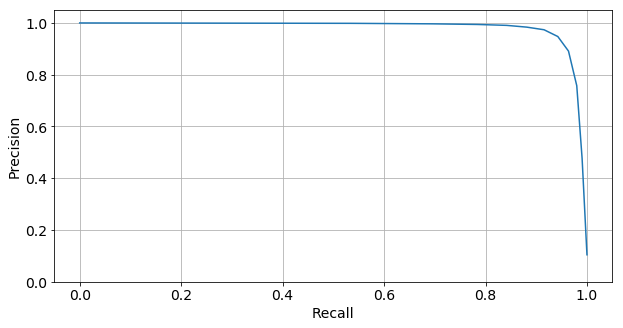

In [42]:
plt.plot(recalls,precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(0,1.05)
plt.grid()

# Multiclass Classification

In [45]:
sgd_clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [46]:
sgd_clf.predict([some_digit])

array(['7'], dtype='|S1')

In [47]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores # shows the scores of each individual classifier, maximum is the prediction

array([[-17787.40162208, -42918.08929707,  -8148.90033113,
         -2659.81475751, -20086.81877557, -10122.27895047,
        -30486.36222492,   4243.21037537,  -6686.32928706,
         -5593.89179295]])

In [48]:
np.argmax(some_digit_scores)

7

In [49]:
sgd_clf.classes_ # here are the target classes

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='|S1')

In [52]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train,y_train)


/Users/hugo/Software/miniconda2/envs/st_test/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [53]:
ovo_clf.predict([some_digit])

array(['7'], dtype=object)

In [54]:
len(ovo_clf.estimators_) #N*(N-1)/2

45

In [55]:
forest_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [56]:
forest_clf.predict([some_digit])

array(['7'], dtype=object)

In [57]:
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [59]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy') 

array([0.87472505, 0.88544427, 0.86247937])

In [61]:
from sklearn.preprocessing import StandardScaler #scaling the inputs can increase the accuracy
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

/Users/hugo/Software/miniconda2/envs/st_test/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89812038, 0.90319516, 0.90423564])

# Error Analysis

After:

- Exploring data
- trying out multiple models,
- shortlisting the best ones
- fine-tuning hyperparameters (using GridSearchCV)

You can improve things by analyzing the errors it makes. 
You need `cross_val_predict()` and `confusion_matrix()`

In [64]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5592,    0,   20,    8,   10,   41,   35,    5,  211,    1],
       [   0, 6424,   43,   19,    3,   47,    5,    8,  181,   12],
       [  28,   31, 5258,   96,   74,   22,   66,   40,  335,    8],
       [  26,   22,  113, 5272,    1,  203,   24,   46,  360,   64],
       [   9,   13,   46,    9, 5239,    9,   35,   21,  307,  154],
       [  28,   19,   29,  155,   56, 4495,   80,   18,  475,   66],
       [  30,   20,   46,    2,   36,   87, 5556,    7,  134,    0],
       [  18,   14,   55,   27,   57,   13,    3, 5714,  159,  205],
       [  16,   61,   40,   91,    3,  125,   31,   10, 5426,   48],
       [  26,   21,   28,   62,  120,   39,    1,  176,  341, 5135]])

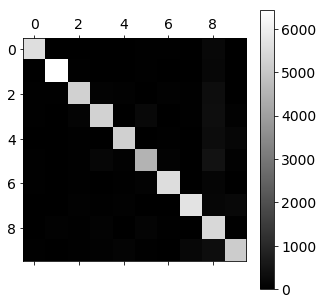

In [95]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
colorbar()

In [104]:
#compare error rates
row_sums = conf_mx.sum(axis=1, keepdims=True,dtype=float)

norm_conf_mx = conf_mx / row_sums

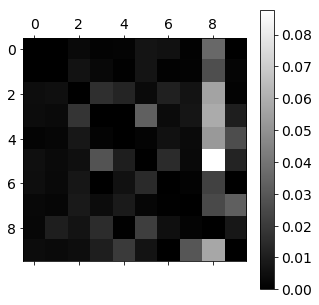

In [105]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
colorbar()

In [109]:
cl_a, cl_b = '5','3'
x_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
x_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
x_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
x_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [110]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

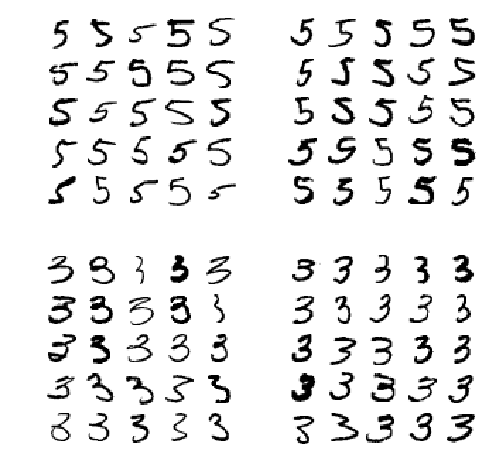

In [111]:

figure(figsize=(8,8))
subplot(221); plot_digits(x_aa[:25],images_per_row=5)
subplot(222); plot_digits(x_ab[:25],images_per_row=5)
subplot(223); plot_digits(x_ba[:25],images_per_row=5)
subplot(224); plot_digits(x_bb[:25],images_per_row=5)

# Multilabel Classification

The output can have multiple binary labels

In [112]:
from sklearn.neighbors import KNeighborsClassifier

In [138]:
y_train_large =(y_train >= '7' )
np.logical_or((y_train == '5'),(y_train=='3')) #or (y_train=='5') or (y_train=='7') or (y_train=='9')

array([False,  True,  True, ..., False,  True, False])

In [139]:
y_multilabel = np.c_[y_train_large,y_train_odd]

In [140]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [141]:
knn_clf.predict([some_digit])

array([[ True, False]])

In [142]:
y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_multilabel,cv=3)

In [143]:
f1_score(y_multilabel,y_train_knn_pred,average='macro')

0.9675265401539301

# Multioutput Classification

In [148]:
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [149]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

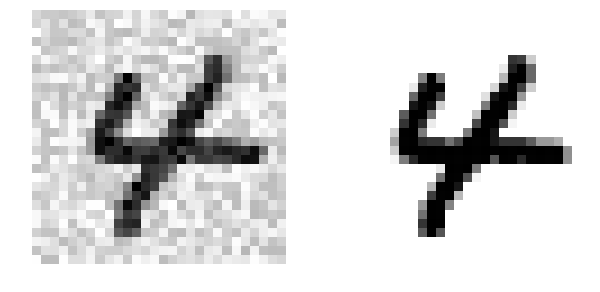

In [150]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])

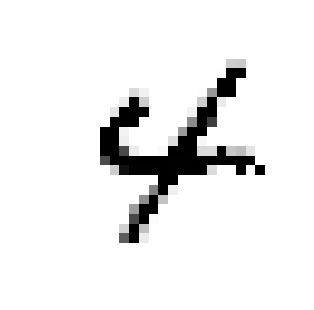

In [151]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

# Exercises

## 1.

In [152]:

from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=3, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 488.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 488.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_neighbors': [3, 4, 5], 'weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [153]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [154]:
grid_search.best_score_

0.97145

In [155]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

## 2.

In [157]:
from scipy.ndimage.interpolation import shift

def shifter(data,dx,dy):
    image = data.reshape(28, 28)
    newimage = shift(image,[dx,dy],cval=0,mode="constant")
    return newimage.reshape([-1])



In [158]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx,dy in ((1,0),(-1,0),(0,1),(0,1)):
    for image, label in zip(X_train,y_train):
        X_train_augmented.append(shifter(image,dx,dy))
        y_train_augmented.append(label)
        
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [159]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [160]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [161]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='distance')

In [162]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9738

## 3. Titanic Data set
Predict who survives. Use data from the [Titanic Challenge](https://www.kaggle.com/c/titanic)

In [163]:
import pandas as pd

train_data = pd.read_csv("datasets/titanic/train.csv")
test_data = pd.read_csv("datasets/titanic/test.csv")

In [164]:
train_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [166]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [168]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [185]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [186]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [187]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Add more attributes to the dataset, since it will probalby have more useful information
Use Dataframeselector from chapter 2


In [189]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y = None):
        return self
    def transform(self,X):
        return X[self.attribute_names].values

In [193]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('select_numeric',DataFrameSelector(['Age','SibSp','Parch','Fare'])),
    ('imputer',SimpleImputer(strategy='median'))
])

num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [223]:
# I had troubles with this class, something related to int or bools for the indeces. Not sure why I wasn't getting that. 
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [228]:
class GeneralImputer(SimpleImputer):
    def __init__(self, **kwargs):
        SimpleImputer.__init__(self, **kwargs)

    def fit(self, X, y=None):
        if self.strategy == 'most_frequent':
            self.fills = pd.DataFrame(X).mode(axis=0).squeeze()
            self.statistics_ = self.fills.values
            return self
        else:
            return SimpleImputer.fit(self, X, y=y)

    def transform(self, X):
        if hasattr(self, 'fills'):
            return pd.DataFrame(X).fillna(self.fills).values.astype(str)
        else:
            return SimpleImputer.transform(self, X)

In [229]:
from sklearn.preprocessing import OneHotEncoder
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", GeneralImputer(strategy='most_frequent')),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [230]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [231]:
# Join both pipelines
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [232]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [234]:
y_train = train_data['Survived']

Now we can train a Machine Learning Model.

In [235]:
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [236]:
for_cl = RandomForestClassifier(n_estimators=100, random_state=42)
for_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)

In [238]:
for_scores

array([0.73333333, 0.81111111, 0.73033708, 0.85393258, 0.87640449,
       0.79775281, 0.83146067, 0.78651685, 0.85393258, 0.84090909])

In [239]:
for_scores.mean()

0.8115690614005221

Adding new features

In [247]:
import string
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if string.find(str(big_string), substring) != -1:
            return substring
    print big_string
    return np.nan

In [240]:
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']
train_passengers = train_data.copy()
train_passengers['Title']=train_passengers['Name'].map(lambda x: substrings_in_string(x, title_list))
 

In [286]:
test_passengers = test_data.copy()
test_passengers['Title']=test_passengers['Name'].map(lambda x: substrings_in_string(x, title_list))

In [288]:
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
train_passengers['Title']=train_passengers.apply(replace_titles, axis=1)
test_passengers['Title']=test_passengers.apply(replace_titles,axis=1)

In [289]:
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'nan']
train_passengers['Deck']=train_passengers['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))

In [290]:
test_passengers['Deck']=test_passengers['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))

In [291]:
train_passengers['Family_Size']=train_passengers['SibSp']+train_passengers['Parch']

In [292]:
test_passengers['Family_Size']=test_passengers['SibSp']+train_passengers['Parch']

In [293]:
train_passengers['Age*Class']=train_passengers['Age']*train_passengers['Pclass']

In [294]:
test_passengers['Age*Class']=test_passengers['Age']*test_passengers['Pclass']

In [295]:
num_pipeline = Pipeline([
    ('select_numeric',DataFrameSelector(['Age*Class','Family_Size','Fare'])),
    ('imputer',SimpleImputer(strategy='median'))
])

num_pipeline.fit_transform(train_passengers)

array([[66.    ,  1.    ,  7.25  ],
       [38.    ,  1.    , 71.2833],
       [78.    ,  0.    ,  7.925 ],
       ...,
       [58.    ,  3.    , 23.45  ],
       [26.    ,  0.    , 30.    ],
       [96.    ,  0.    ,  7.75  ]])

In [296]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked","Deck","Title"])),
        ("imputer", GeneralImputer(strategy='most_frequent')),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])
cat_pipeline.fit_transform(train_passengers)

array([[0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [297]:
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [298]:
X_train = preprocess_pipeline.fit_transform(train_passengers)


In [299]:
y_train = train_passengers['Survived']

In [300]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train,y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [301]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=5)
forest_scores.mean()

0.8002930363179914

In [302]:
num_pipeline.fit_transform(test_passengers)
cat_pipeline.fit_transform(test_passengers)
X_test = preprocess_pipeline.fit_transform(test_passengers)

y_pred = forest_clf.predict(X_test)

ValueError: Number of features of the model must match the input. Model n_features is 24 and input n_features is 23 

In [305]:
X_train.shape

(891, 24)

In [306]:
X_test.shape

(418, 23)